In [38]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy # linear algebra
# data processing, CSV file I/O (e.g. pd.read_csv)
import pandas as pd

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/summer-school-2022-task-2/train_data.csv
/kaggle/input/summer-school-2022-task-2/test_data.csv
/kaggle/input/summer-school-2022-task-2/sample_submssions.csv


In [39]:
import cudf as df
import cupy as np

In [40]:
#loading the dataset
train = df.read_csv('/kaggle/input/summer-school-2022-task-2/train_data.csv')
train.dropna(how = 'any', inplace = True, axis = 0)
print(train.shape)
train.head()

(208764, 16)


,id,seller,offer_type,price,abtest,vehicle_type,year_of_registration,gearbox,power,model,kilometer,month_of_registration,fuel_type,brand,not_repaired_damage,postal_code
0,0,privat,Angebot,8990,control,bus,2007,automatik,136,b_klasse,125000,1,benzin,mercedes_benz,nein,55232
1,1,privat,Angebot,49900,test,suv,2011,automatik,400,cayenne,80000,6,benzin,porsche,nein,89155
2,2,privat,Angebot,7500,control,limousine,2005,manuell,0,a6,150000,11,diesel,audi,nein,26125
3,3,privat,Angebot,1350,control,limousine,1997,manuell,170,3er,150000,5,benzin,bmw,nein,37671
4,4,privat,Angebot,650,test,kombi,1998,automatik,170,e_klasse,150000,8,benzin,mercedes_benz,ja,45141


In [41]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [42]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 30.75 MB
Memory usage after optimization is: 7.57 MB
Decreased by 75.4%


In [43]:
train.dtypes

id                          int32
seller                   category
offer_type               category
price                       int32
abtest                   category
vehicle_type             category
year_of_registration        int16
gearbox                  category
power                       int16
model                    category
kilometer                   int32
month_of_registration        int8
fuel_type                category
brand                    category
not_repaired_damage      category
postal_code                 int32
dtype: object

In [44]:
train.describe()

,id,price,year_of_registration,power,kilometer,month_of_registration,postal_code
count,208764.000000,2.087640e+05,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000
mean,104381.500000,8.563905e+03,2003.297863,126.385857,124031.011094,6.181717,51851.998620
std,60265.120136,3.837843e+05,6.528143,144.950397,39859.350281,3.472495,25850.643904
min,0.000000,0.000000e+00,1910.000000,0.000000,5000.000000,0.000000,1067.000000
25%,52190.750000,1.500000e+03,1999.000000,78.000000,100000.000000,3.000000,31241.000000
50%,104381.500000,3.850000e+03,2004.000000,116.000000,150000.000000,6.000000,51105.000000
75%,156572.250000,8.600000e+03,2008.000000,150.000000,150000.000000,9.000000,72770.000000
max,208763.000000,1.000000e+08,2018.000000,17700.000000,150000.000000,12.000000,99998.000000


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


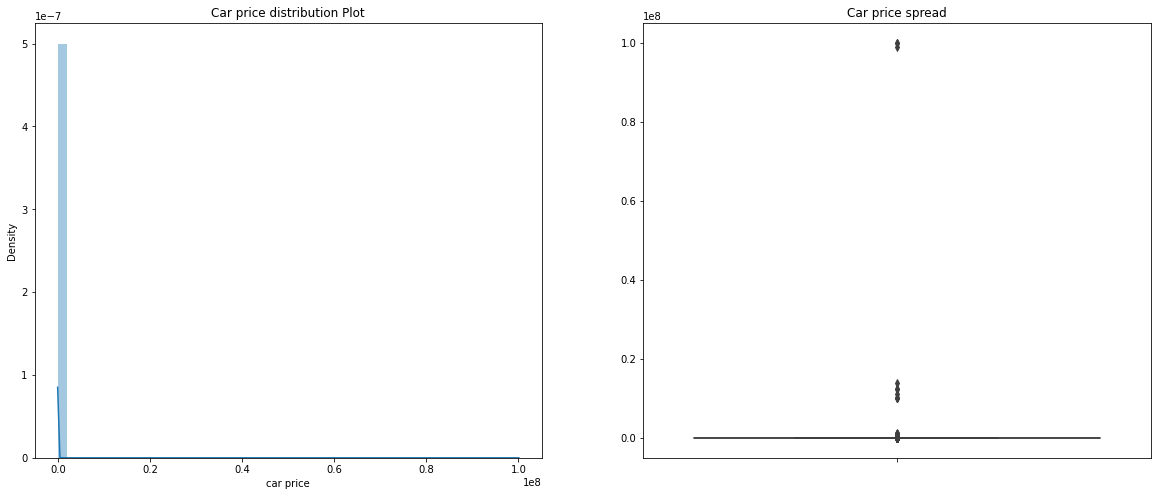

In [45]:
# car price distribution plot
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20,8))

plt.subplot(1,2,1)
sns.distplot(train.price.to_array(), axlabel = 'car price', kde = True)
plt.title('Car price distribution Plot')

plt.subplot(1,2,2)
sns.boxplot(y = train.price.to_array())
plt.title('Car price spread')

plt.show()


Prices of cars are hightly right skewed with mean value closer to 10000

In [46]:
train['brand'].unique()

0        alfa_romeo
1              audi
2               bmw
3         chevrolet
4          chrysler
5           citroen
6             dacia
7            daewoo
8          daihatsu
9              fiat
10             ford
11            honda
12          hyundai
13           jaguar
14             jeep
15              kia
16             lada
17           lancia
18       land_rover
19            mazda
20    mercedes_benz
21             mini
22       mitsubishi
23           nissan
24             opel
25          peugeot
26          porsche
27          renault
28            rover
29             saab
30             seat
31            skoda
32            smart
33           subaru
34           suzuki
35           toyota
36          trabant
37       volkswagen
38            volvo
Name: brand, dtype: category
Categories (39, object): ['alfa_romeo', 'audi', 'bmw', 'chevrolet', ..., 'toyota', 'trabant', 'volkswagen', 'volvo']

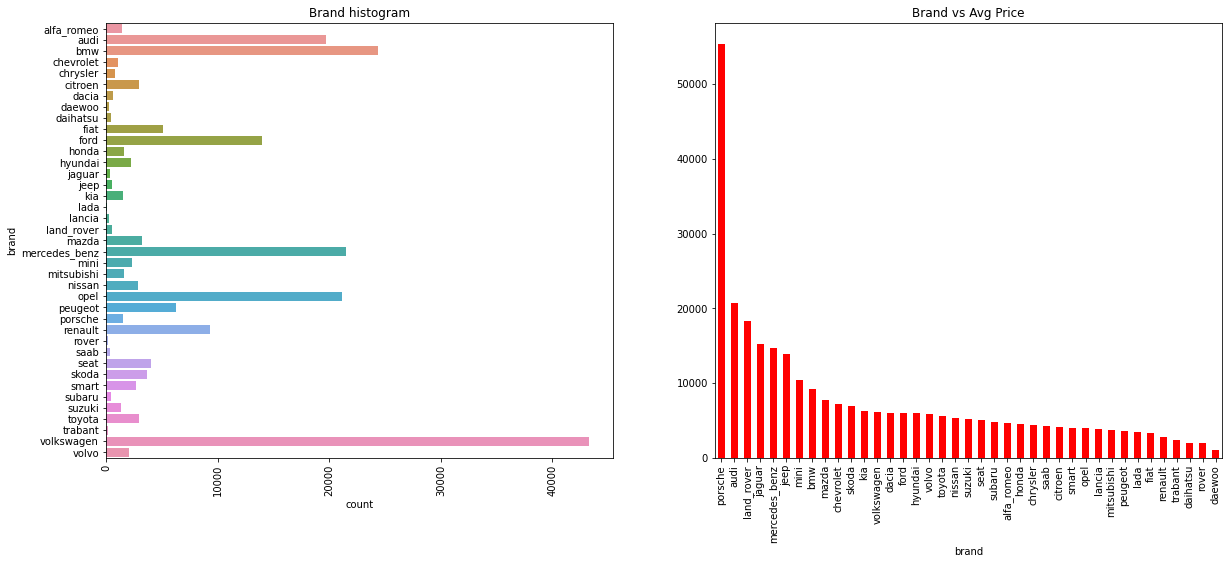

In [47]:
plt.figure(figsize = (20,8))
plt.subplot(1,2,1)
sns.countplot(y = train.brand.to_pandas(),orient = 'v')
plt.xticks(rotation = 90)
plt.title('Brand histogram')

plt.subplot(1,2,2)
brand_price = (train.groupby(['brand']).price.mean().sort_values(ascending = False)).to_pandas()
brand_price.plot.bar(x = 'brand', y = 'price', color = 'red')
plt.title("Brand vs Avg Price") 
plt.show()

Volkswagen is the predominant brand in the market while Posche bringing the costliest one

In [48]:
def bar_plot(column_name):
    plt.figure(figsize = (6,4))
    sns.countplot(train[column_name].to_pandas())
    plt.xticks(rotation = 90)
    plt.title(column_name + ' histogram')
    plt.show()

In [49]:
train.columns

Index(['id', 'seller', 'offer_type', 'price', 'abtest', 'vehicle_type',
       'year_of_registration', 'gearbox', 'power', 'model', 'kilometer',
       'month_of_registration', 'fuel_type', 'brand', 'not_repaired_damage',
       'postal_code'],
      dtype='object')

In [50]:
import numpy
#stats of categorical columns
train.describe(include = ['category'], exclude = [numpy.number])

,seller,offer_type,abtest,vehicle_type,gearbox,model,fuel_type,brand,not_repaired_damage
count,208764,208764,208764,208764,208764,208764,208764,208764,208764
unique,2,2,2,8,2,250,7,39,2
top,privat,Angebot,test,limousine,manuell,golf,benzin,volkswagen,nein
freq,208762,208761,108590,61082,159980,16765,135504,43302,186424


Hence, it is irrelevant to plot a histogram for the feature, 'model' which has around 250 unique entries

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


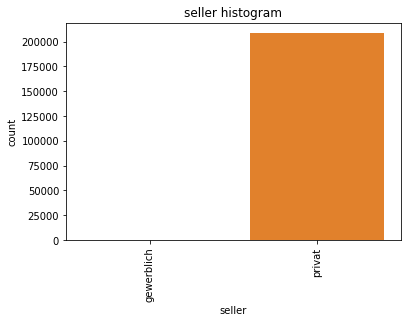

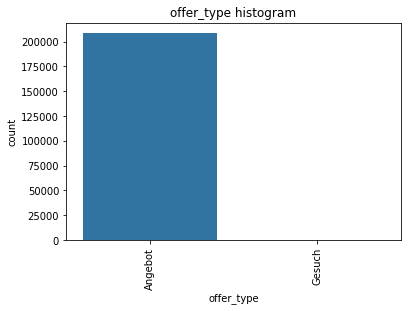

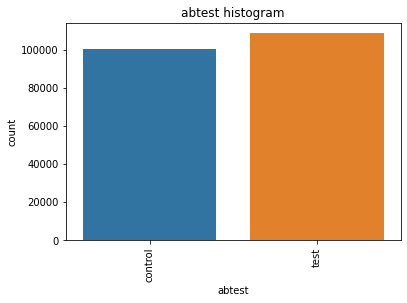

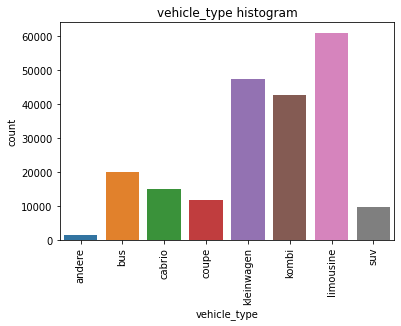

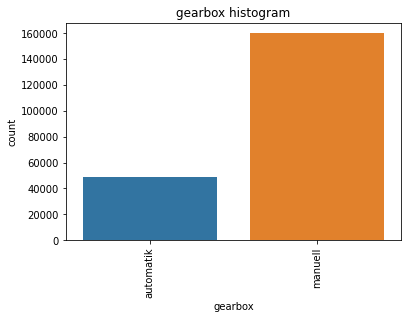

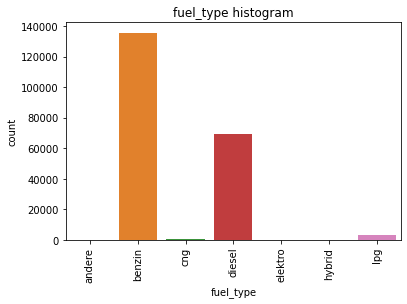

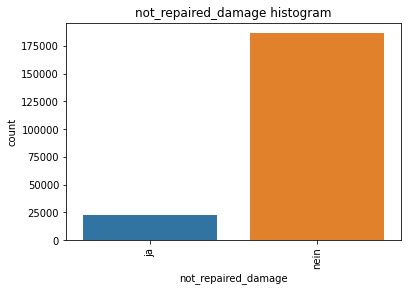

In [51]:
features = ['seller', 'offer_type', 'abtest', 'vehicle_type', 'gearbox', 'fuel_type', 'not_repaired_damage']
for feature in features:
    bar_plot(feature)

From the above count plots we can infer that most of the cars are sold on offer (angebot) by a private individual having manual gearbox and not repaired after damage (nein ~ no)

In [52]:
def feature_price(features):
    plt.figure(figsize = (20,10))
    plt.subplot(1,2,1)
    brand_price = (train.groupby([feature]).price.mean().sort_values(ascending = False)).to_pandas()
    brand_price.plot.bar(x = feature, y = 'price')
    plt.title(feature + " vs Avg Price") 
    
    plt.subplot(1,2,2)
    plt.title(feature + ' vs Price')
    sns.boxplot(x=train[features].to_pandas(), y=train['price'].to_array(), palette=("PuBuGn"))
    plt.show()

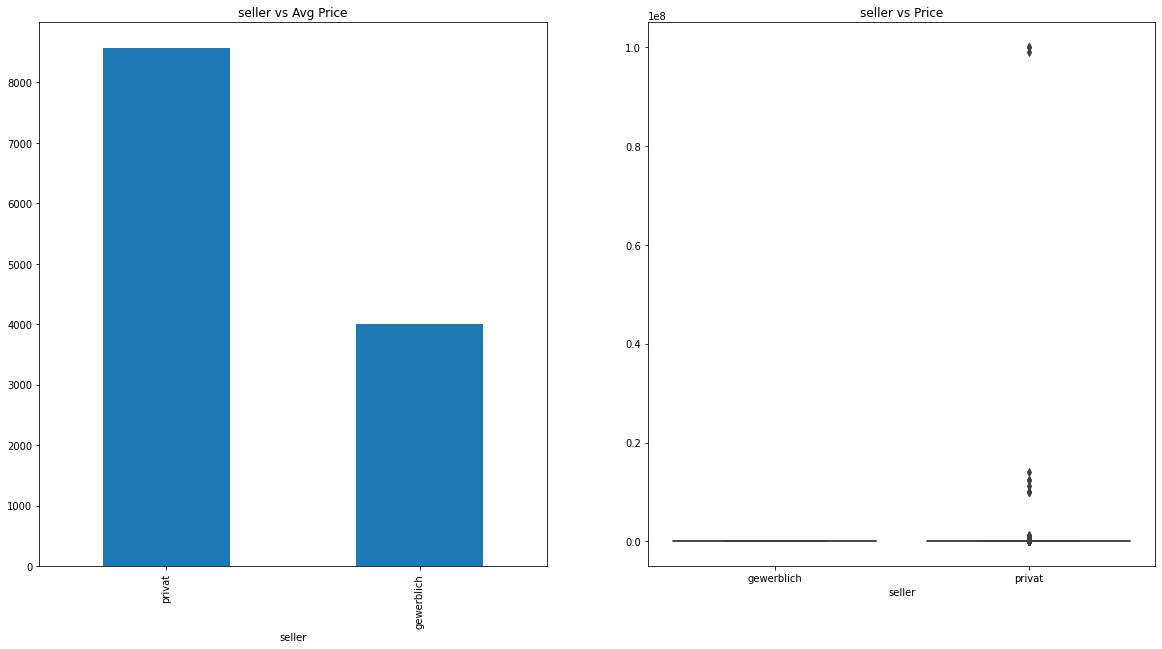

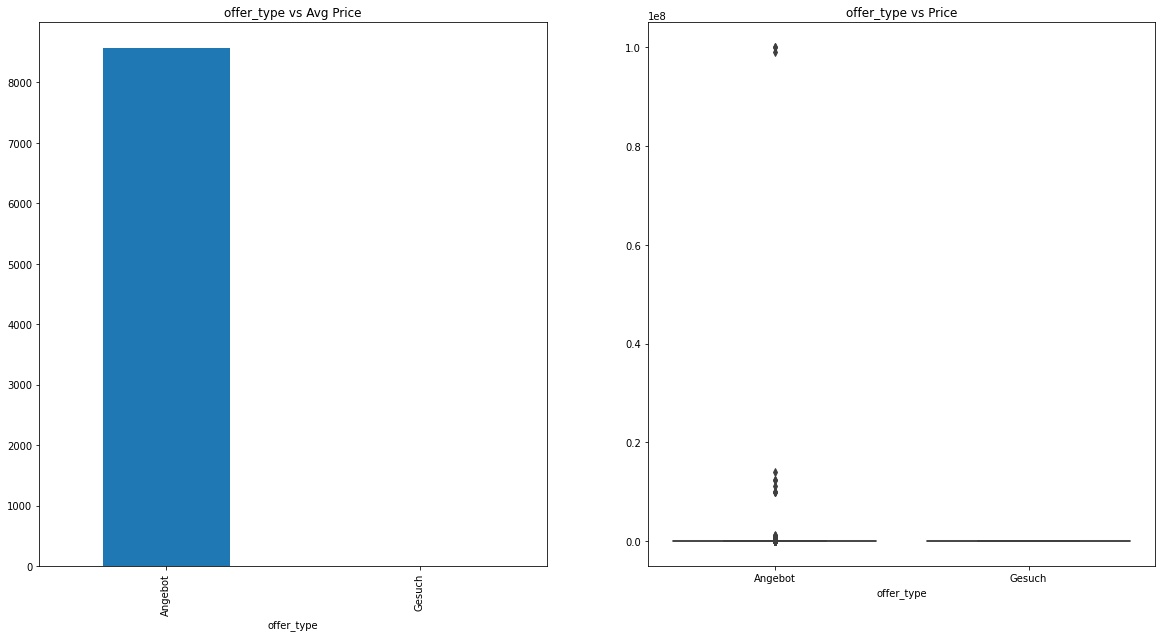

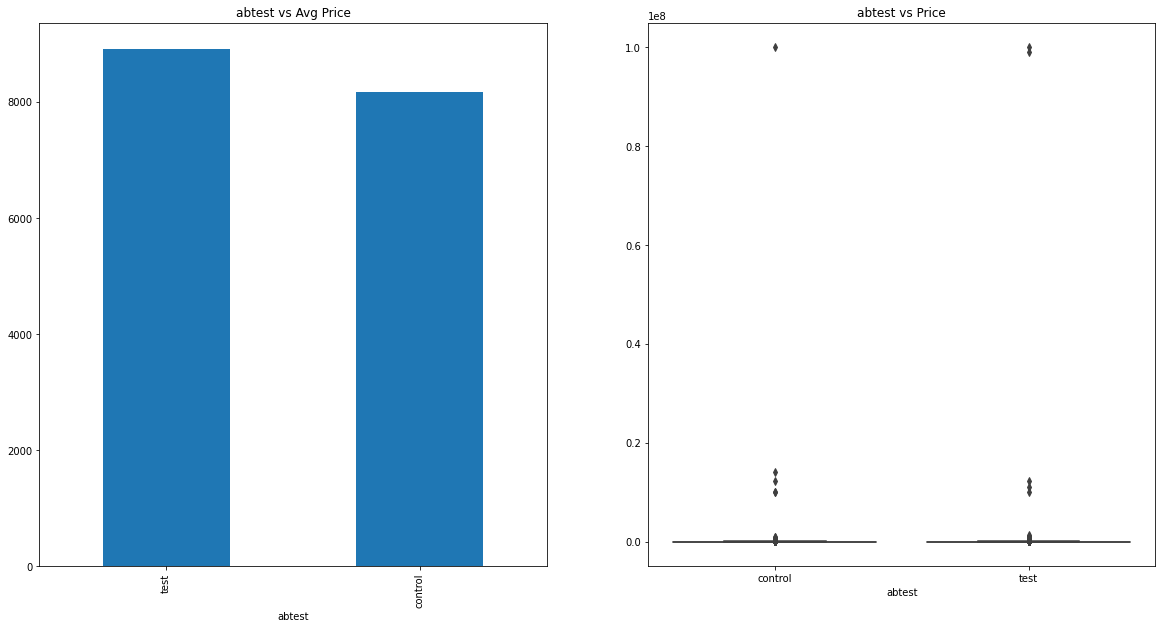

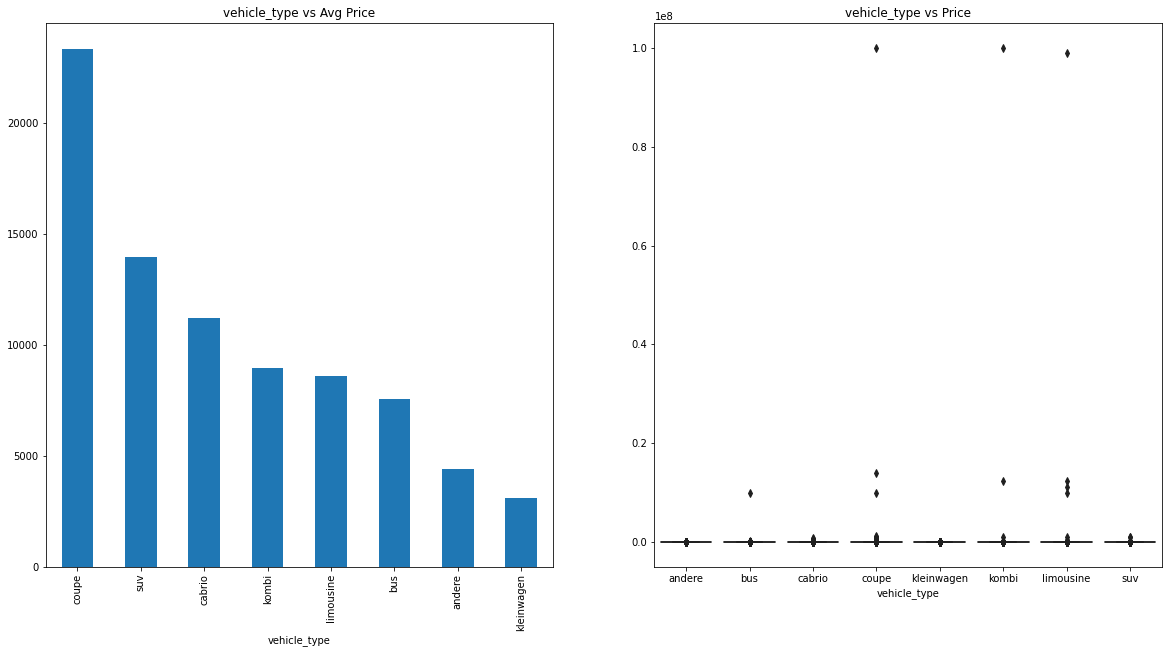

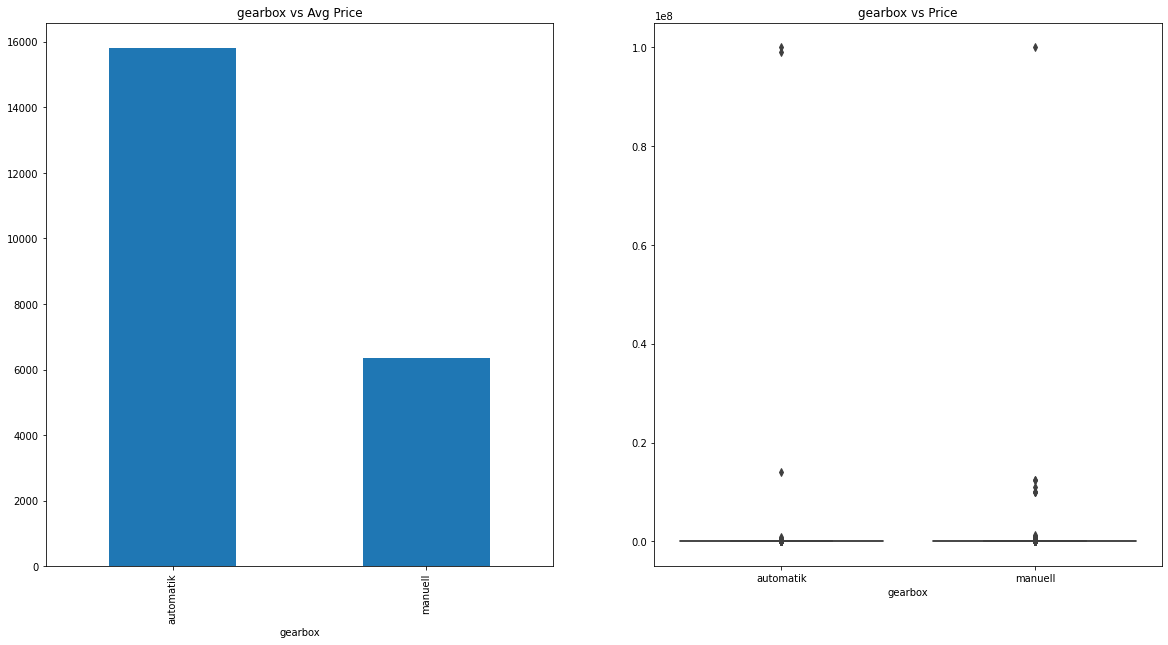

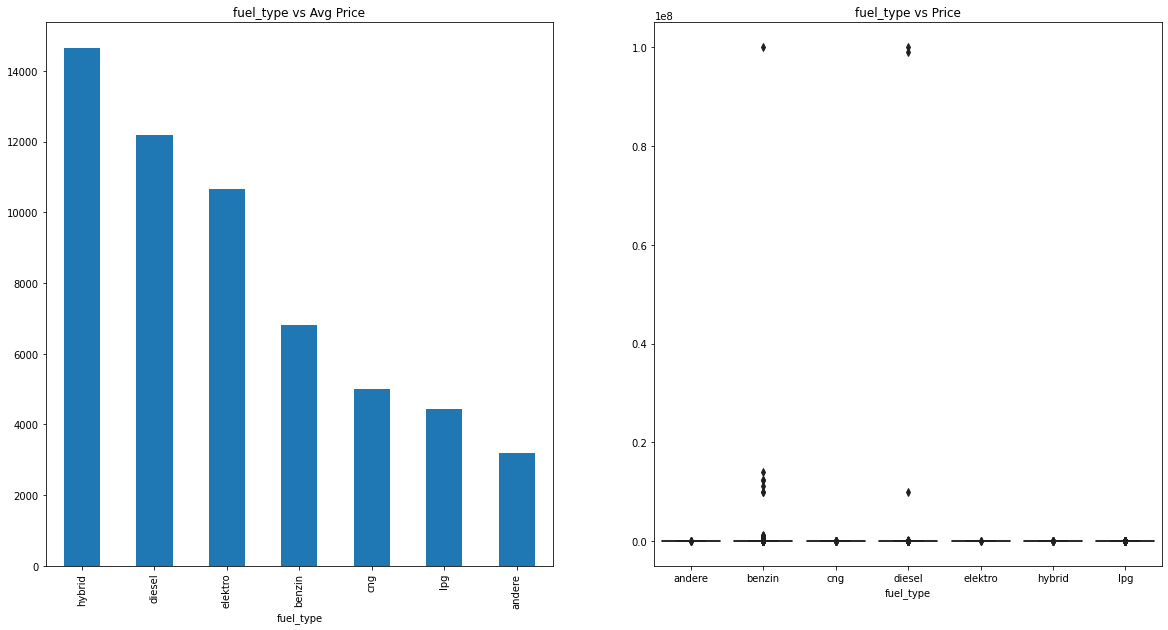

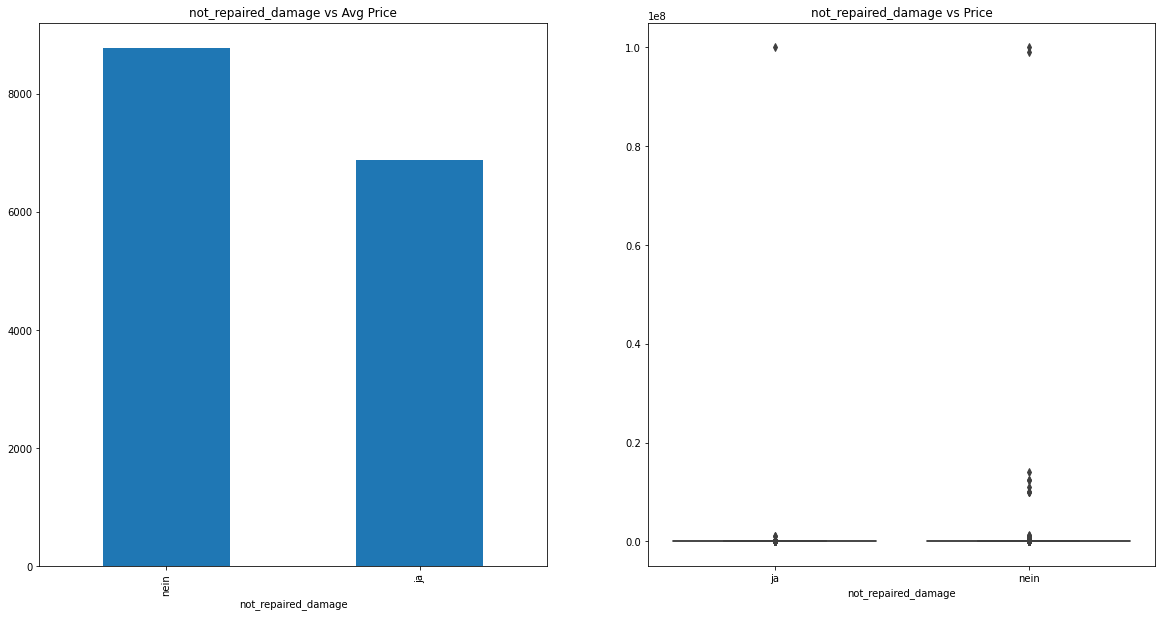

In [53]:
for feature in features:
    feature_price(feature)

From the boxplot of all features, we can conclude that the price is close to 10000 mark in respect to most of the features but the distribution is affected in some by few outliers, possibly from Posche car which sets themselves at the price range of 10^7

Relation of numeric columns with target variabel (price)

In [54]:
train.describe(include = [numpy.number], exclude = 'category')

,id,price,year_of_registration,power,kilometer,month_of_registration,postal_code
count,208764.000000,2.087640e+05,208764.000000,208764.000000,208764.000000,208764.000000,208764.000000
mean,104381.500000,8.563905e+03,2003.297863,126.385857,124031.011094,6.181717,51851.998620
std,60265.120136,3.837843e+05,6.528143,144.950397,39859.350281,3.472495,25850.643904
min,0.000000,0.000000e+00,1910.000000,0.000000,5000.000000,0.000000,1067.000000
25%,52190.750000,1.500000e+03,1999.000000,78.000000,100000.000000,3.000000,31241.000000
50%,104381.500000,3.850000e+03,2004.000000,116.000000,150000.000000,6.000000,51105.000000
75%,156572.250000,8.600000e+03,2008.000000,150.000000,150000.000000,9.000000,72770.000000
max,208763.000000,1.000000e+08,2018.000000,17700.000000,150000.000000,12.000000,99998.000000


In [55]:
def scatter_plot(fig_number, feature, data):
    plt.subplot(2,2,fig_number)
    plt.scatter(data[feature].to_array(), data['price'].to_array())
    plt.title(feature + ' vs price')
    plt.xlabel(feature)
    plt.ylabel('price')

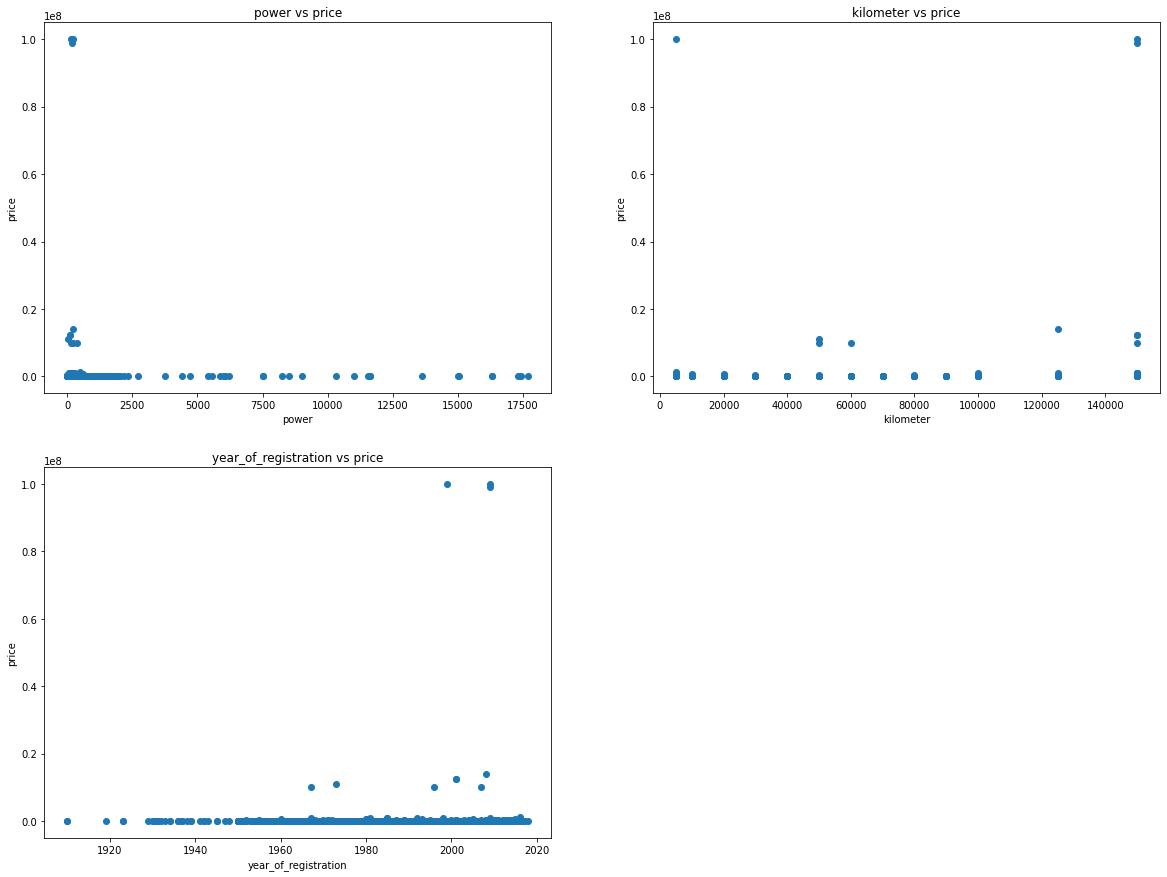

In [56]:
plt.figure(figsize = (20,15))
for i,feature in enumerate(['power', 'kilometer', 'year_of_registration'],1):
    scatter_plot(i, feature, train)

array([[<AxesSubplot:title={'center':'year_of_registration'}>,
        <AxesSubplot:title={'center':'power'}>],
       [<AxesSubplot:title={'center':'kilometer'}>,
        <AxesSubplot:title={'center':'price'}>]], dtype=object)

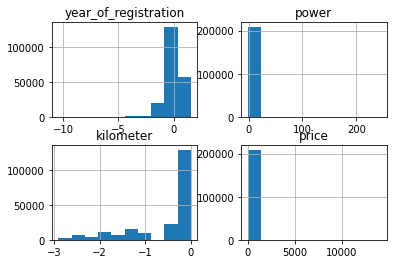

In [57]:
data.to_pandas().hist()

In [58]:
from sklearn.preprocessing import RobustScaler
data = train[['year_of_registration', 'power', 'kilometer', 'price']]
trans = RobustScaler()
data = trans.fit_transform(data.as_matrix())
data = df.DataFrame(data, columns = ['year_of_registration', 'power', 'kilometer', 'price'])
data.describe()

,year_of_registration,power,kilometer,price
count,208764.000000,208764.000000,208764.000000,208764.000000
mean,-0.078015,0.144248,-0.519380,0.663930
std,0.725349,2.013200,0.797187,54.054120
min,-10.444444,-1.611111,-2.900000,-0.542254
25%,-0.555556,-0.527778,-1.000000,-0.330986
50%,0.000000,0.000000,0.000000,0.000000
75%,0.444444,0.472222,0.000000,0.669014
max,1.555556,244.222222,0.000000,14083.964648


array([[<AxesSubplot:title={'center':'year_of_registration'}>,
        <AxesSubplot:title={'center':'power'}>],
       [<AxesSubplot:title={'center':'kilometer'}>,
        <AxesSubplot:title={'center':'price'}>]], dtype=object)

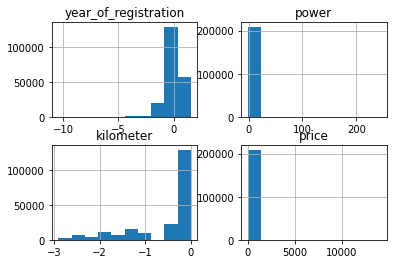

In [59]:
data.to_pandas().hist()

In [60]:
train[['year_of_registration', 'power', 'kilometer', 'price']] = data

In [61]:
train.head()

,id,seller,offer_type,price,abtest,vehicle_type,year_of_registration,gearbox,power,model,kilometer,month_of_registration,fuel_type,brand,not_repaired_damage,postal_code
0,0,privat,Angebot,0.723944,control,bus,0.333333,automatik,0.277778,b_klasse,-0.5,1,benzin,mercedes_benz,nein,55232
1,1,privat,Angebot,6.485915,test,suv,0.777778,automatik,3.944444,cayenne,-1.4,6,benzin,porsche,nein,89155
2,2,privat,Angebot,0.514085,control,limousine,0.111111,manuell,-1.611111,a6,0.0,11,diesel,audi,nein,26125
3,3,privat,Angebot,-0.352113,control,limousine,-0.777778,manuell,0.750000,3er,0.0,5,benzin,bmw,nein,37671
4,4,privat,Angebot,-0.450704,test,kombi,-0.666667,automatik,0.750000,e_klasse,0.0,8,benzin,mercedes_benz,ja,45141


In [62]:
train.drop(columns = ['id', 'month_of_registration'], inplace = True)


In [71]:
train = df.get_dummies(train, columns = ['seller', 'offer_type', 'abtest', 'vehicle_type', 
                                    'gearbox', 'fuel_type', 'not_repaired_damage'])

In [73]:
train.drop(columns = ['postal_code'], inplace = True)


In [74]:
train.head()

,price,year_of_registration,power,model,kilometer,brand,seller_gewerblich,seller_privat,offer_type_Angebot,offer_type_Gesuch,...,gearbox_manuell,fuel_type_andere,fuel_type_benzin,fuel_type_cng,fuel_type_diesel,fuel_type_elektro,fuel_type_hybrid,fuel_type_lpg,not_repaired_damage_ja,not_repaired_damage_nein
0,0.723944,0.333333,0.277778,b_klasse,-0.5,mercedes_benz,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
1,6.485915,0.777778,3.944444,cayenne,-1.4,porsche,0,1,1,0,...,0,0,1,0,0,0,0,0,0,1
2,0.514085,0.111111,-1.611111,a6,0.0,audi,0,1,1,0,...,1,0,0,0,1,0,0,0,0,1
3,-0.352113,-0.777778,0.750000,3er,0.0,bmw,0,1,1,0,...,1,0,1,0,0,0,0,0,0,1
4,-0.450704,-0.666667,0.750000,e_klasse,0.0,mercedes_benz,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0


In [76]:
#separating the label from predictor variables
from sklearn.model_selection import train_test_split
trainy = train['price']
trainx = train.drop(labels = ['price'], axis = 1)
train_x, val_x, train_y, val_y = train_test_split(trainx, trainy, test_size = 0.1, random_state = 2, shuffle = True)
print('We have around {} training examples with {} predictor variables'.format(train_x.shape[0], train_x.shape[1]))
print("We have around {} validation examples with {} predictor variables".format(val_x.shape[0], val_x.shape[1]))
del train
del trainx
del trainy
gc.collect()


TypeError: take() got an unexpected keyword argument 'axis'

In [ ]:
#preprocessing continous variables
from sklearn.preprocessing import MinMaxScaler

def preprocess(df):
    df = drop_columns(df, ['id', 'month_of_registration', 'postal_code', 'offer_type', 'not_repaired_damage', 'seller', 'abtest'])
    df.reset_index(drop = True, inplace = True)
    
    
    scaler = MinMaxScaler()
    # scaler.fit(df[['power', 'kilometer','year_of_registration']])
    scaled = scaler.fit_transform(df[['power', 'kilometer','year_of_registration']])

    scaled_df = pd.DataFrame(scaled, columns = ['power', 'kilometer',  'year_of_registration'])
    del scaled
    gc.collect()
    df.drop(columns = ['power', 'kilometer', 'year_of_registration'], axis = 1, inplace = True)
    df = pd.concat([df, scaled_df], axis = 1)
    df = pd.get_dummies(df, columns = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand'])
    return df

In [ ]:
train = preprocess(train.to_pandas())

In [ ]:
#creating submission file
def submission(id, price):
    submit = pd.DataFrame()
    submit['id'] = id
    submit['price'] = price
    submit.to_csv('submission.csv', index = False)

In [ ]:
submission(test['id'], pred_rand_reg)